References:
https://www.kaggle.com/slashtea/domain-generation-algorithm?select=words.txt
https://splunkbase.splunk.com/app/3559/#/details
Cisco Database: http://s3-us-west-1.amazonaws.com/umbrella-static/index.html

In [91]:
import pandas as pd
import numpy as np

1. Data Exploration

Reading and cleaning the data into the usable format

In [92]:
words_loc = "archive/words.txt"
top_1m_loc = "archive/top-1m.csv"
dga_project_top_1m_loc = "archive/dga_project_top-1m.csv"
dga_project_dga_domain_list_clean_loc = "archive/dga_project_dga_domain_list_clean.txt"

In [93]:
dga_project_top_1m = pd.read_csv(dga_project_top_1m_loc, names=["rating", "domain"])
dga_project_top_1m["label"] = "real"

print(dga_project_top_1m.head())
print(len(dga_project_top_1m))

   rating       domain label
0       1   google.com  real
1       2  youtube.com  real
2       3    tmall.com  real
3       4    baidu.com  real
4       5       qq.com  real
491987


In [94]:
top_1m = pd.read_csv(top_1m_loc, names=["rating", "domain"])
top_1m["label"] = "real"
top_1m["subclasses"] = "real"

print(top_1m.head())
print(len(top_1m))

   rating       domain label subclasses
0       1   google.com  real       real
1       2  youtube.com  real       real
2       3    tmall.com  real       real
3       4       qq.com  real       real
4       5    baidu.com  real       real
694787


In [95]:
words = open(words_loc, "r")
words = words.read()
words = words.split()

dga_project_dga_domain_list_clean = open(dga_project_dga_domain_list_clean_loc, "r")
dga_project_dga_domain_list_clean = dga_project_dga_domain_list_clean.read()
dga_project_dga_domain_list_clean = dga_project_dga_domain_list_clean.split()


In [96]:
print(words[:5])
print(len(words))
print(dga_project_dga_domain_list_clean[:10])
print(len(dga_project_dga_domain_list_clean))

['2', '1080', '&c', '10-point', '10th']
466550
['nymaim', 'vvqbhhwma.org', '2021-05-11', '00:00:00', '2021-05-11', '23:59:59', 'nymaim', 'cfhauqbaz.com', '2021-05-11', '00:00:00']
8428752


In [97]:
dga_domain = dga_project_dga_domain_list_clean[1::6]
print(dga_domain[:5])

dga_domain_subclasses = dga_project_dga_domain_list_clean[::6]
print(dga_domain_subclasses[:5])

['vvqbhhwma.org', 'cfhauqbaz.com', 'bvxjsbkqu.biz', 'hggazskvkdy.com', 'xgoqyxgfgm.com']
['nymaim', 'nymaim', 'nymaim', 'nymaim', 'nymaim']


Creating a dataset with labels.
We will combine "top_1m" with label 0 (not dga) and "dga_project_dga_domain_list_clean_domains" with the label 1 (dga).
Two rows: name, label

Combining feature matrix and Labels matrix

In [98]:
fake_domains = pd.DataFrame()
fake_domains["domain"] = dga_domain
fake_domains["subclasses"] = dga_domain_subclasses
fake_domains["label"] = "fake"
fake_domains["rating"] = None
print(fake_domains.head())

            domain subclasses label rating
0    vvqbhhwma.org     nymaim  fake   None
1    cfhauqbaz.com     nymaim  fake   None
2    bvxjsbkqu.biz     nymaim  fake   None
3  hggazskvkdy.com     nymaim  fake   None
4   xgoqyxgfgm.com     nymaim  fake   None


In [99]:
data = pd.concat([fake_domains, top_1m], ignore_index=True)
print(data.head())
print(len(fake_domains))
print(len(top_1m))
print(len(fake_domains)+len(top_1m))
print(len(data))

            domain subclasses label rating
0    vvqbhhwma.org     nymaim  fake   None
1    cfhauqbaz.com     nymaim  fake   None
2    bvxjsbkqu.biz     nymaim  fake   None
3  hggazskvkdy.com     nymaim  fake   None
4   xgoqyxgfgm.com     nymaim  fake   None
1404792
694787
2099579
2099579


2. Feature Engineering and Visualization

In [100]:
import math
from collections import Counter
# import tldextract

In [101]:
def entropy(domain_name):
    """ Function which computes the entropy of a given domain name based on it's chars """
    elements, length = Counter(domain_name), len(domain_name)    
    
    return -sum(element/length * math.log(element/length, 2) for element in elements.values())

In [102]:
data["length"] = data["domain"].apply(lambda domain: len(domain))
data["entropy"] = data["domain"].apply(lambda domain: entropy(domain))

In [103]:
import sklearn.feature_extraction as fe


split_condition = data["label"] == "real"
legit = data[split_condition]
# dga = data[~split_condition]

In [104]:
alexa_vc = fe.text.CountVectorizer(analyzer="char", ngram_range=(3,5), min_df=0.00001, max_df=1.0)
counts_matrix = alexa_vc.fit_transform(legit["domain"])

In [105]:
alexa_counts = np.log10(np.asarray(counts_matrix.sum(axis=0)).flatten())
data["alexa_grams"] = alexa_counts * alexa_vc.transform(data["domain"]).T

In [106]:
# Adding another feature digit/char ration

def ration(word):
    l = len(word)
    ch = 0
    for w in word:
        if w.isalpha():
            ch+=1
    return ch/l

data["ration"] = data["domain"].apply(lambda domain: ration(domain))


In [107]:
print(data.head())

            domain subclasses label rating  length   entropy  alexa_grams  \
0    vvqbhhwma.org     nymaim  fake   None      13  3.392747    35.073993   
1    cfhauqbaz.com     nymaim  fake   None      13  3.392747    50.365824   
2    bvxjsbkqu.biz     nymaim  fake   None      13  3.334679    21.710086   
3  hggazskvkdy.com     nymaim  fake   None      15  3.640224    50.786285   
4   xgoqyxgfgm.com     nymaim  fake   None      14  3.039149    37.869187   

     ration  
0  0.923077  
1  0.923077  
2  0.923077  
3  0.933333  
4  0.928571  


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


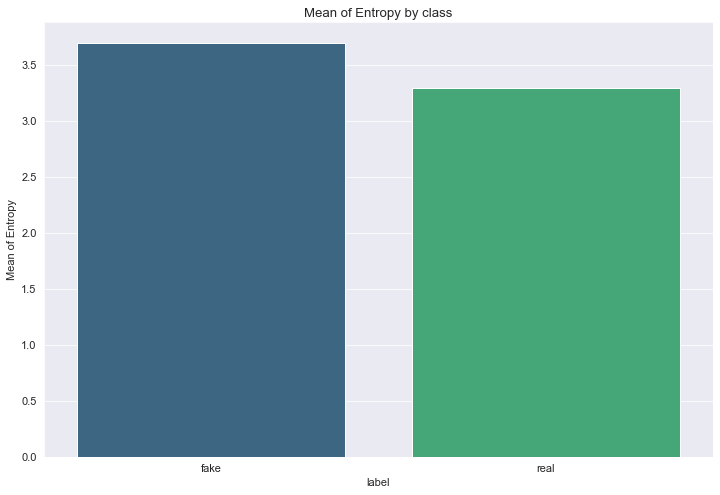

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12,8)
font = {"size"   : 11}

plt.rc('font', **font)


mean_entropy = data.groupby("label")["entropy"].agg("mean")
sns.barplot(mean_entropy.index, mean_entropy.values, palette="viridis")

plt.ylabel("Mean of Entropy")
plt.title("Mean of Entropy by class")
plt.show()

In [109]:
# Creating TLD column
from urllib.parse import urlparse
urlparse("cfhauqbaz.com")
#Not very useful

ParseResult(scheme='', netloc='', path='cfhauqbaz.com', params='', query='', fragment='')

3. Create Machine Learnings Models

Model

In [110]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

In [111]:
def get_ration(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, stratify=y)
    lb = LabelEncoder()

    y_train = lb.fit_transform(y_train)
    y_test = lb.transform(y_test)

    lgb_clf = lgb.LGBMClassifier()

    lgb_clf.fit(X_train, y_train)
    y_pred = lgb_clf.predict(X_test)
    print("Evaluation f1 score metric is {}%".format(round(f1_score(y_test, y_pred) * 100), 2))

In [112]:
get_ration(data[["length", "entropy"]], data["label"])

Evaluation f1 score metric is 72%


In [113]:
get_ration(data[["length", "entropy", "alexa_grams"]], data["label"])

Evaluation f1 score metric is 93%


In [114]:
get_ration(data[["length", "entropy", "alexa_grams", "ration"]], data["label"])

Evaluation f1 score metric is 95%


4. Operationalize ML

5. Test and Benchmark